# Shifting eigenvalues with Beta

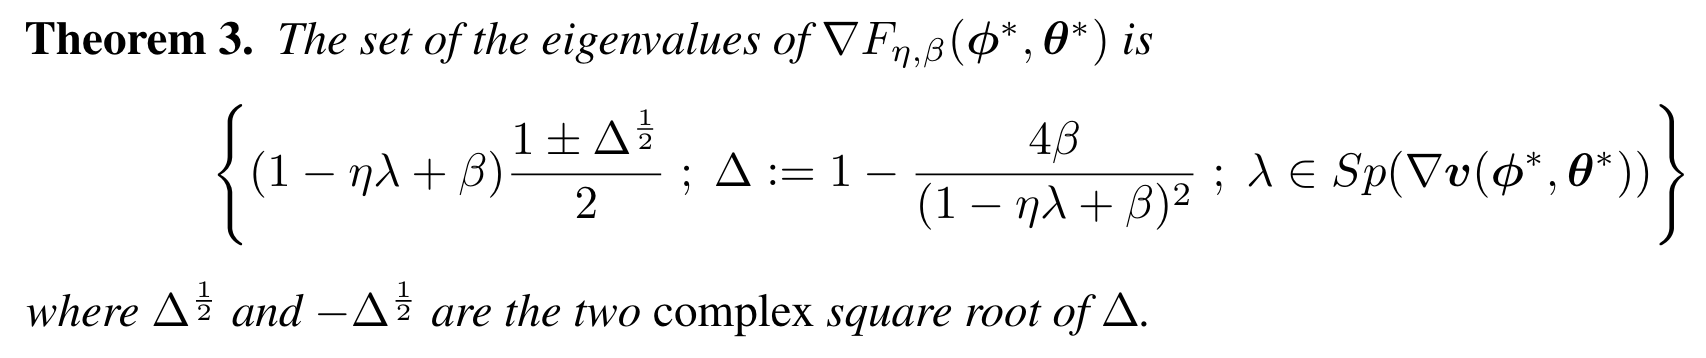

## Backlog:
- generate GIF
- export the matrix

In [1]:
import numpy as np
import os
from scipy.linalg import eigvals
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
cm = matplotlib.cm.get_cmap('Spectral')
import pylab
pylab.rcParams['figure.figsize'] = 8,8
from collections import OrderedDict
from tqdm import tqdm
import imageio

In [2]:
def shift_eigs_old(eigs_current, eta, beta):
    discriminant = (1-eta* eigs_current +beta)**2 - 4*beta
    new_eigs1 = 0.5 * (1 - eta*eigs_current + beta + np.sqrt(discriminant))
    new_eigs2 = 0.5 * (1 - eta*eigs_current + beta - np.sqrt(discriminant))
    new_eigs = np.vstack((new_eigs1, new_eigs2))
    return new_eigs

def shift_eigs(eigs_current, eta, beta):
    discriminant = 1 - 4*beta / (1-eta* eigs_current +beta)**2
    new_eigs1 = 0.5 * (1 - eta*eigs_current + beta) * (1 + np.sqrt(discriminant))
    new_eigs2 = 0.5 * (1 - eta*eigs_current + beta) * (1 - np.sqrt(discriminant))
    new_eigs = np.vstack((new_eigs1, new_eigs2))
    return new_eigs

def square_root(z, theta):
    "Square root with different branch cut defined by alpha parameter."
    argument = np.angle(z) # between -pi and +pi
    modulus = np.abs(z)
    argument = np.mod(argument + theta, 2 * np.pi) - theta
    return np.sqrt(modulus) * np.exp(1j * argument / 2)

def shift_eigs_branchcut(eigs_current, eta, beta, theta=0.):
    discriminant = 1 - 4*beta / (1-eta* eigs_current +beta)**2
    new_eigs1 = 0.5 * (1 - eta*eigs_current + beta) * (1 + square_root(discriminant, theta))
    new_eigs2 = 0.5 * (1 - eta*eigs_current + beta) * (1 - square_root(discriminant, theta))
    new_eigs = np.vstack((new_eigs1, new_eigs2))
    return new_eigs

theta = 0.

In [18]:
def export_animation(name, eig_m, beta, export_anim=True, plot_links=False, nofigure=False):

    if not nofigure:
        anim_dir = 'plots/anim_{}'.format(name)
        if not os.path.exists(anim_dir):
            os.makedirs(anim_dir)

    if export_anim:
        n_plots = 50
        display = False
    else:
        n_plots = 10
        display = True

    plot_rate = True    
    plot_momentum_rate = True    

    etas = np.linspace(0, 2, n_plots)
    #etas = np.linspace(1.33, 1.56, n_plots)

    circle_alpha = 0.6
    markersize = 80

    # Precompute all trajectories
    trajectories = OrderedDict()
    trajectories.setdefault('eta', OrderedDict())
    trajectories.setdefault('eig_f_eta', OrderedDict())
    trajectories.setdefault('eig_f_1', OrderedDict())
    trajectories.setdefault('momentum_eig_f_eta', OrderedDict())
    trajectories.setdefault('rate', OrderedDict())
    trajectories.setdefault('momentum_rate', OrderedDict())

    for i, eta in enumerate(etas):
        eig_f_eta = 1 - eta * eig_m
        eig_f_1 = 1 - eig_m
        momentum_eig_f_eta = shift_eigs(eig_m, eta, beta).flatten()

        trajectories['eta'][i] = eta
        trajectories['eig_f_eta'][i] = eig_f_eta  
        trajectories['eig_f_1'][i] = eig_f_1  
        trajectories['momentum_eig_f_eta'][i] = momentum_eig_f_eta  
        trajectories['rate'][i] = np.max(np.abs(eig_f_eta))
        trajectories['momentum_rate'][i] = np.max(np.abs(momentum_eig_f_eta))

    trajectory_alpha = 0.1

    if nofigure:
        return np.min(trajectories['rate'].values()), np.min(trajectories['momentum_rate'].values())        
        
    for i, eta in enumerate(tqdm(etas)):
        plt.figure()
        ax = plt.gca()

        # Plot whole trajectory
        path = np.asarray(trajectories['eig_f_eta'].values())
        plt.scatter(path.real, path.imag, color='xkcd:red', alpha=trajectory_alpha)
        momentum_path = np.asarray(trajectories['momentum_eig_f_eta'].values())
        plt.scatter(momentum_path.real, momentum_path.imag, color='xkcd:azure', alpha=trajectory_alpha)

        # Plot optimal rates
        if plot_rate:
            ax.add_patch(plt.Circle((0,0), radius=np.min(trajectories['rate'].values()), fill=False, linewidth=2,
                                color='xkcd:red', alpha=circle_alpha, zorder=1))       
        if plot_momentum_rate:
            ax.add_patch(plt.Circle((0,0), radius=np.min(trajectories['momentum_rate'].values()), fill=False, linewidth=2,
                                color='xkcd:green', alpha=circle_alpha, zorder=1))  


        # Move left y-axis and bottim x-axis to centre, passing through (0,0)
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # Unit circle
        ax.add_patch(plt.Circle((0,0), radius=1, fill=False, linewidth=3, color='xkcd:blue', zorder=0, alpha=circle_alpha))
        plt.xlim((-1.3,1.3))
        plt.ylim((-1.3,1.3))

        eig_f_eta = 1 - eta * eig_m
        eig_f_1 = 1 - eig_m

        plt.plot([1], [0], color='black', marker='o')
        plt.scatter(eig_f_eta.real, eig_f_eta.imag, facecolor='xkcd:red', edgecolor='black', 
                    marker='o', s=markersize, zorder=3)    #plt.scatter(eig_f_1.real, eig_f_1.imag, color='xkcd:green', marker='o', zorder=3, s=markersize)

        # Compute maximum value
        spectral_norm = np.max(np.abs(eig_f_eta))
        ax.add_patch(plt.Circle((0,0), radius=spectral_norm, fill=False, linewidth=2,
                                color='xkcd:red', linestyle='dashed', alpha=circle_alpha, zorder=1))

        # Shift value with momentum
        momentum_eig_f_eta = shift_eigs(eig_m, eta, beta).flatten()
        plt.scatter(momentum_eig_f_eta.real, momentum_eig_f_eta.imag, facecolor='xkcd:azure', edgecolor='black', 
                    marker='o', s=markersize, zorder=3)
        momentum_spectral_norm = np.max(np.abs(momentum_eig_f_eta))
        ax.add_patch(plt.Circle((0,0), radius=momentum_spectral_norm, linewidth=2,
                                fill=False, color='xkcd:green', linestyle='dashed', alpha=circle_alpha, zorder=1))

        #for eig in eig_f_1:
        #    plt.plot([1, eig.real], [0, eig.imag], color='grey', dashes=[6, 2])
        for eig, shifted in zip(eig_f_eta, momentum_eig_f_eta[:len(eig_f_eta)]):
            if display:
                print '->', eig, shifted
            #plt.arrow(eig.real, eig.imag, 
            #          shifted.real-eig.real, shifted.imag-eig.imag,
            #          head_width=0.02, head_length=0.05, linewidth=0.2, zorder=2,
            #         )#length_includes_head=True)  # why the fuck does it not work?
            if plot_links:  # this is not ideal, it's hard to find associations
                plt.plot([eig.real, shifted.real], [eig.imag, shifted.imag], color='grey', dashes=[6, 2])

        title = 'Eta={:.2f} Beta={:.2f} 1-mu: {:.2f} -> {:.2f}'.format(eta, beta, spectral_norm, momentum_spectral_norm)
        if display:
            plt.title(title)
        else:
            with open('{}/params_{:03d}.txt'.format(anim_dir, i), 'w') as fp:
                fp.write(title)
                
        if export_anim:
            plt.savefig('{}/pdf_{:03d}.pdf'.format(anim_dir, i), bbox_inches='tight')
            plt.savefig('{}/png_{:03d}.png'.format(anim_dir, i), bbox_inches='tight')
        if not display:
            plt.close()
        else:
            plt.show()
            
    return np.min(trajectories['rate'].values()), np.min(trajectories['momentum_rate'].values())

In [4]:
# Start with a antisymmetric matrix
m = np.array([
       [ 1,  0, -1,  0],
       [ 0,  1,  0, -1],
       [ 1,  0,  0,  0],
       [ 0,  1,  0,  0]])
eig_m = eigvals(m)
print eig_m
name = 'gaussian_gan'
beta = -0.25
export_animation(name, eig_m, beta, export_anim=True)

[0.5+0.8660254j 0.5-0.8660254j 0.5+0.8660254j 0.5-0.8660254j]


In [7]:
def shift_eigs_debug(eigs_current, eta, beta):
    discriminant = (1-eta* eigs_current +beta)**2 - 4*beta
    new_eigs1 = 0.5 * (1 - eta*eigs_current + beta + np.sqrt(discriminant))
    new_eigs2 = 0.5 * (1 - eta*eigs_current + beta - np.sqrt(discriminant))
    new_eigs = np.vstack((new_eigs1, new_eigs2))
    
    print 'discriminant', discriminant
    print 'new_eigs1', new_eigs1
    print 'new_eigs2', new_eigs2
    return new_eigs

shift_eigs_debug(eig_m, 0.1, -0.25)

discriminant [1.4825-0.12124356j 1.4825+0.12124356j 1.4825-0.12124356j
 1.4825+0.12124356j]
new_eigs1 [0.95929771-0.0681749j 0.95929771+0.0681749j 0.95929771-0.0681749j
 0.95929771+0.0681749j]
new_eigs2 [-0.25929771-0.01842764j -0.25929771+0.01842764j -0.25929771-0.01842764j
 -0.25929771+0.01842764j]


array([[ 0.95929771-0.0681749j ,  0.95929771+0.0681749j ,
         0.95929771-0.0681749j ,  0.95929771+0.0681749j ],
       [-0.25929771-0.01842764j, -0.25929771+0.01842764j,
        -0.25929771-0.01842764j, -0.25929771+0.01842764j]])

In [20]:
# Another antisymmetric matrix
m = np.array([
       [ 1,  0, -1,  0],
       [ 0,  1,  0, -1],
       [ 1,  0,  1,  0],
       [ 0,  1,  0,  1]])
eig_m = eigvals(m)
print eig_m
name = 'other'
beta = -0.25
export_animation(name, eig_m, beta, export_anim=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[1.+1.j 1.-1.j 1.+1.j 1.-1.j]


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


(0.7072540184148349, 0.5114048737267348)

In [21]:
# Badly conditioned adversarial part
a = 1
b = 0.1
m = np.array([
       [ 1,  0, -a,  0],
       [ 0,  1,  0, -b],
       [ a,  0,  1,  0],
       [ 0,  b,  0,  1]])
eig_m = eigvals(m)
print eig_m
name = 'other_bad_cond'
theta = 0.
beta = -0.25
export_animation(name, eig_m, beta, export_anim=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[1.+1.j  1.-1.j  1.+0.1j 1.-0.1j]


100%|██████████| 50/50 [00:20<00:00,  2.44it/s]


(0.7072540184148349, 0.5114048737267348)

In [22]:
# Purely Adversarial
a = 1
b = 0.1
m = np.array([
       [ 0,  0, -a,  0],
       [ 0,  0,  0, -b],
       [ a,  0,  0,  0],
       [ 0,  b,  0,  0]])
eig_m = eigvals(m)
print eig_m
name = 'pure_adversarial'
theta = 0.
beta = -0.9
export_animation(name, eig_m, beta, export_anim=True)

  0%|          | 0/50 [00:00<?, ?it/s]

[0.+1.j  0.-1.j  0.+0.1j 0.-0.1j]


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


(1.0, 1.0000000000000002)

In [23]:
# More cooperative to more adversarial
for one_minus_alpha in np.linspace(0, 1, 11):
    alpha = 1 - one_minus_alpha
    m = np.array([
           [ 1-alpha,  0, -alpha,  0],
           [ 0,  1-alpha,  0, -alpha],
           [ alpha,  0,  1-alpha,  0],
           [ 0,  alpha,  0,  1-alpha]])
    eig_m = eigvals(m)
    print eig_m
    beta = -0.25

    print 'Exporting for alpha={}'.format(alpha)
    export_animation('mix_{:.2f}'.format(alpha), eig_m, beta, export_anim = True)

  0%|          | 0/50 [00:00<?, ?it/s]

[0.+1.j 0.-1.j 0.+1.j 0.-1.j]
Exporting for alpha=1.0


  0%|          | 0/50 [00:00<?, ?it/s]

[0.1+0.9j 0.1-0.9j 0.1+0.9j 0.1-0.9j]
Exporting for alpha=0.9


  0%|          | 0/50 [00:00<?, ?it/s]

[0.2+0.8j 0.2-0.8j 0.2+0.8j 0.2-0.8j]
Exporting for alpha=0.8


  0%|          | 0/50 [00:00<?, ?it/s]

[0.3+0.7j 0.3-0.7j 0.3+0.7j 0.3-0.7j]
Exporting for alpha=0.7


  0%|          | 0/50 [00:00<?, ?it/s]

[0.4+0.6j 0.4-0.6j 0.4+0.6j 0.4-0.6j]
Exporting for alpha=0.6


  0%|          | 0/50 [00:00<?, ?it/s]

[0.5+0.5j 0.5-0.5j 0.5+0.5j 0.5-0.5j]
Exporting for alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

[0.6+0.4j 0.6-0.4j 0.6+0.4j 0.6-0.4j]
Exporting for alpha=0.4


  0%|          | 0/50 [00:00<?, ?it/s]

[0.7+0.3j 0.7-0.3j 0.7+0.3j 0.7-0.3j]
Exporting for alpha=0.3


  0%|          | 0/50 [00:00<?, ?it/s]

[0.8+0.2j 0.8-0.2j 0.8+0.2j 0.8-0.2j]
Exporting for alpha=0.2


  0%|          | 0/50 [00:00<?, ?it/s]

[0.9+0.1j 0.9-0.1j 0.9+0.1j 0.9-0.1j]
Exporting for alpha=0.1


  0%|          | 0/50 [00:00<?, ?it/s]

[1.+0.j 1.+0.j 1.+0.j 1.+0.j]
Exporting for alpha=0.0


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


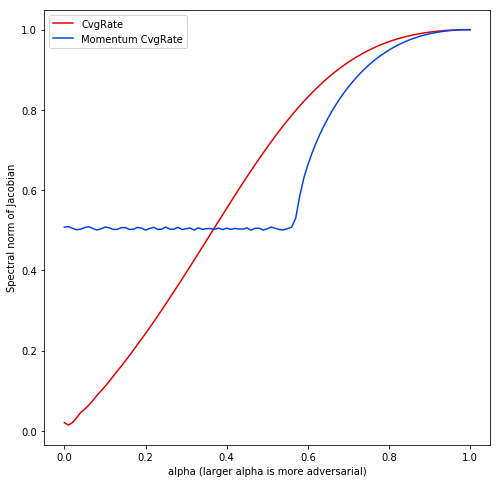

In [24]:
# Badly conditioned adversarial part
alphas = np.linspace(0, 1, 101)
rates = []
momentum_rates = []
for alpha in alphas:
    a = 1
    b = 0.1
    m = np.array([
           [ 1-alpha,  0, -alpha,  0],
           [ 0,  1-alpha,  0, -alpha],
           [ alpha,  0,  1-alpha,  0],
           [ 0,  alpha,  0,  1-alpha]])
    eig_m = eigvals(m)
    beta = -0.25

    #print 'Exporting for alpha={}'.format(alpha)
    #print eig_m
    rate, momentum_rate = export_animation('mix_{:.2f}'.format(alpha), eig_m, beta, export_anim=True, nofigure=True)
    rates.append(rate)
    momentum_rates.append(momentum_rate)
    
plt.plot(alphas, rates, label='CvgRate', color='xkcd:red')
plt.plot(alphas, momentum_rates, label='Momentum CvgRate', color='xkcd:blue')
plt.legend()
plt.xlabel('alpha (larger alpha is more adversarial)')
plt.ylabel('Spectral norm of Jacobian')
plt.savefig('adversarial.pdf', bbox_inches='tight')

  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.0


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.1


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.2


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.3


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.4


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.5


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.6


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.7


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.8


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=0.9


  0%|          | 0/50 [00:00<?, ?it/s]

Exporting for alpha=1.0


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


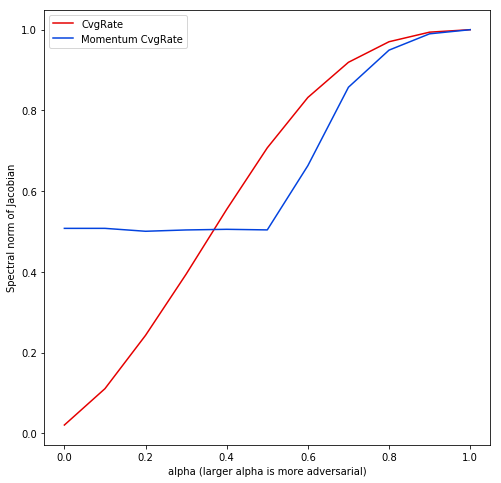

In [7]:
# Badly conditioned adversarial part
alphas = np.linspace(0, 1, 11)
rates = []
momentum_rates = []
for alpha in alphas:
    a = 1
    b = 0.1
    m = np.array([
           [ 1-alpha,  0, -alpha,  0],
           [ 0,  1-alpha,  0, -alpha],
           [ alpha,  0,  1-alpha,  0],
           [ 0,  alpha,  0,  1-alpha]])
    eig_m = eigvals(m)
    beta = -0.25

    print 'Exporting for alpha={}'.format(alpha)
    rate, momentum_rate = export_animation('mix_{:.2f}'.format(alpha), eig_m, beta, export_anim=True)
    rates.append(rate)
    momentum_rates.append(momentum_rate)
    
plt.plot(alphas, rates, label='CvgRate', color='xkcd:red')
plt.plot(alphas, momentum_rates, label='Momentum CvgRate', color='xkcd:blue')
plt.legend()
plt.xlabel('alpha (larger alpha is more adversarial)')
plt.ylabel('Spectral norm of Jacobian')
plt.savefig('adversarial.pdf', bbox_inches='tight')